In [23]:
import keras
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import mean_squared_error
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import Flatten, Dense, Input, Embedding, Dot
from keras.layers import GlobalAveragePooling1D, MaxPooling1D, Dropout, BatchNormalization
from keras.optimizers import Adam

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data
movie = [i.strip().split("::") for i in open("/content/drive/My Drive/MovieLens10M/movies.dat").readlines()]
movie = pd.DataFrame(movie)
movie = movie.rename(columns={0: "movieId", 1: "title"})
rating = [i.strip().split("::") for i in open("/content/drive/My Drive/MovieLens10M/ratings.dat").readlines()]
rating = pd.DataFrame(rating)
rating = rating.rename(columns={0: "userId", 1: "movieId", 2: "rating", 3: "timestamp"})
movie = movie.loc[:,["movieId"]]
rating = rating.loc[:,["userId","movieId","rating","timestamp"]]
data = pd.merge(rating, movie)
data['rating'] = pd.to_numeric(data['rating'])
data['timestamp'] = pd.to_numeric(data['timestamp'])

In [4]:
# preprocessing
n_movies = len(data['movieId'].unique())
n_users = len(data['userId'].unique())
users = data.userId.unique()
movies = data.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

data['userId'] = data['userId'].apply(lambda x: userid2idx[x])
data['movieId'] = data['movieId'].apply(lambda x: movieid2idx[x])

min_timestamp = pd.DataFrame(data.loc[:,["movieId","timestamp"]].groupby(['movieId'], as_index=False).min())
min_timestamp = min_timestamp.sort_values(by=["movieId"], axis=0)
min_timestamp = min_timestamp.rename(columns={"timestamp": "min_timestamp"})
data = pd.merge(data, min_timestamp)
data['timestamp'] = data['timestamp'] - data['min_timestamp']
data['timestamp'] = data['timestamp'] / (60 * 60 * 24 * 365)
data = data.drop(columns=['min_timestamp'])
data['day'] = data['timestamp'] * 365 / (7 * 2)
data['day'] = data['day'].apply(lambda x: int(x))
days = data.day.unique()
n_days = len(days)
day2idx = {o:i for i,o in enumerate(days)}
data['day'] = data['day'].apply(lambda x: day2idx[x])
print(n_movies, n_users, len(rating), n_days)

10677 69878 10000054 365


In [5]:
# split train and test data
data = data.sample(frac=1)
split = np.random.rand(len(data)) < 0.9
train = data[split]
valid = data[~split]
data.head(10)

,userId,movieId,rating,timestamp,day
1968245,6301,187,4.0,3.384477,158
4455425,21244,716,5.0,7.869160,151
9543638,32083,5006,4.0,0.207300,20
1402168,3338,124,5.0,0.151631,19
7570571,23668,1985,4.5,0.550004,65
3864049,17846,549,1.0,2.020942,221
8089051,23424,2418,2.5,3.625604,43
4261897,24446,650,3.0,3.267586,320
2987399,17491,375,4.0,1.053587,188
4479464,4848,726,2.0,0.095504,25


In [6]:
# generate model
embedding_l2 = 1e-6 * 1                                  # regularization
dense_l2 = 1e-3 * 1                                      # regularization
keras.backend.clear_session()

embedding_l2 /= 2
dense_l2 /= 2
user_input = Input(shape=(1,), name='user_input', dtype='int32')
movie_input = Input(shape=(1,), name='movie_input', dtype='int32')
day_input = Input(shape=(1,), name='day_input', dtype='int32')
time_input = Input(shape=(1,), name='time_input', dtype='float32')
time_root = tf.math.sqrt(time_input + 1.0)
time_square = tf.math.square(time_input)
time_vector = tf.concat([time_input, time_root, time_square], 1)

def create_model(n_user_embedding):
    n_movie_embedding = n_user_embedding

    user_embedding = Embedding(n_users, n_user_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(user_input)
    user_vector = Flatten()(user_embedding)
    movie_embedding = Embedding(n_movies, n_movie_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(movie_input)
    movie_vector = Flatten()(movie_embedding)
    day_embedding = Embedding(n_days, int(n_user_embedding/8), embeddings_regularizer=regularizers.l2(embedding_l2))(day_input)
    day_vector = Flatten()(day_embedding)

    concat_layer = tf.concat([user_vector, movie_vector, time_vector, day_vector], 1)
    mlp_output = Dense(int(n_user_embedding/2), activation='relu', kernel_regularizer=regularizers.l2(dense_l2))(concat_layer)

    user_embedding2 = Embedding(n_users, n_user_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(user_input)
    user_vector2 = Flatten()(user_embedding2)
    movie_embedding2 = Embedding(n_movies, n_movie_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(movie_input)
    movie_vector2 = Flatten()(movie_embedding2)
    MF = Dot(axes=1)([user_vector2, movie_vector2])

    user_embedding3 = Embedding(n_users, n_user_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(user_input)
    user_vector3 = Flatten()(user_embedding3)
    movie_embedding3 = Embedding(n_movies, n_movie_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(movie_input)
    movie_vector3 = Flatten()(movie_embedding3)
    diff = tf.math.subtract(user_vector3, movie_vector3)
    W = tf.Variable(tf.random.normal(shape=[n_user_embedding, 1], stddev=0.1))
    MF2 = tf.linalg.matmul(diff, W)

    output_layer = tf.concat([mlp_output, MF, MF2], 1)
    return output_layer

output_layer = tf.concat([create_model(16*x) for x in range(1,9)], 1)
output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(dense_l2))(output_layer)
output = output*5.5

model = Model([user_input, movie_input, time_input, day_input], output)
model.summary()

The following Variables were used a Lambda layer's call (tf.linalg.matmul), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(16, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.linalg.matmul_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(32, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.linalg.matmul_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(48, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an

In [7]:
# training
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=Adam(1e-3 / 2), loss='mse', metrics=[rmse])
batch_size = 4096*8
epochs = 128

callback = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=1, restore_best_weights=True)
history = model.fit([train.userId, train.movieId, train.timestamp, train.day], train.rating,
                batch_size=batch_size, epochs=epochs, callbacks=[callback],
                validation_data = ([valid.userId, valid.movieId, valid.timestamp, valid.day], valid.rating), verbose = 1)

Epoch 1/128
275/275 [==============================] - 538s 2s/step - loss: 1.2058 - rmse: 0.9839 - val_loss: 0.8171 - val_rmse: 0.8615
Epoch 2/128
275/275 [==============================] - 507s 2s/step - loss: 0.7949 - rmse: 0.8561 - val_loss: 0.7730 - val_rmse: 0.8559
Epoch 3/128
275/275 [==============================] - 515s 2s/step - loss: 0.7463 - rmse: 0.8407 - val_loss: 0.7046 - val_rmse: 0.8154
Epoch 4/128
275/275 [==============================] - 513s 2s/step - loss: 0.6325 - rmse: 0.7684 - val_loss: 0.6637 - val_rmse: 0.7852
Epoch 5/128
 85/275 [========>.....................] - ETA: 5:43 - loss: 0.5045 - rmse: 0.6756

KeyboardInterrupt: ignored

0.7748249229233704


(array([4.09000e+02, 4.41800e+03, 2.09460e+04, 8.96070e+04, 3.17263e+05,
        4.21927e+05, 1.29890e+05, 1.36550e+04, 8.84000e+02, 4.30000e+01]),
 array([-4.20515108, -3.37845971, -2.55176834, -1.72507697, -0.8983856 ,
        -0.07169423,  0.75499715,  1.58168852,  2.40837989,  3.23507126,
         4.06176263]),
 <a list of 10 Patch objects>)

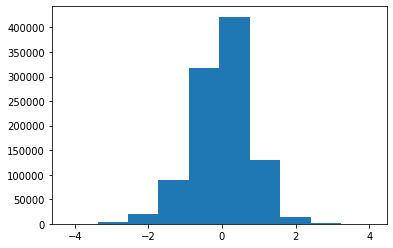

In [30]:
# check final RMSE
valid_pred = model.predict([valid.userId, valid.movieId, valid.timestamp, valid.day], batch_size = batch_size)
valid['pred'] = pd.DataFrame([float(x) for x in valid_pred], index=valid.index, columns=['pred'])
valid['pred'] = valid['pred'].apply(lambda x: max(min(x, 5), 0.5))

test_rmse = mean_squared_error(valid.rating, valid.pred, squared=False) # squared=False -> RMSE
print(test_rmse)
plt.hist(valid['rating'] - valid['pred'])

In [29]:
history = model.fit([train.userId, train.movieId, train.timestamp, train.day], train.rating,
                batch_size=batch_size, epochs=1, callbacks=[callback],
                validation_data = ([valid.userId, valid.movieId, valid.timestamp, valid.day], valid.rating), verbose = 1)

275/275 [==============================] - 495s 2s/step - loss: 0.4519 - rmse: 0.6298 - val_loss: 0.6593 - val_rmse: 0.7748
